# Finetune a Langage Model with Fast.ai
Notebook based on:
- https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb
- https://github.com/fastai/course-nlp/blob/master/5-nn-imdb.ipynb

Video:
- https://www.youtube.com/watch?v=WjnwWeGjZcM (From 0:00 to 55:00)

#### Get latest Fast.ai version (without installing the Pytorch dependency)

In [1]:
!pip install --upgrade --no-deps fastai
!pip install --upgrade --no-deps fastcore

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### Imports

In [1]:
from fastai.text.all import * # We need fastai version 2 for this
from pathlib import Path

#### Check GPU usage

In [2]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("WARNING: Not GPU detected")

Using GPU: GeForce GTX 1080 Ti


# Get data

In [3]:
CLOUD = False

In [4]:
if CLOUD:
    # Download the data from internet
    # If you are using cloud platforms
    # like Google Colab or Kaggle kernels
    data_path = untar_data(URLs.IMDB)
else:
    # Point to the path where the data is
    # located at your local machine
    data_path = Path("../../Datasets/NLP/IMBd")
    
print("Dataset is loacted at:", data_path)

Dataset is loacted at: ../../Datasets/NLP/IMBd


In [5]:
print("Train:", len(list( (data_path/"train").glob('**/*.txt') )), "reviews")
print("Test: ", len(list( (data_path/"test").glob('**/*.txt')  )), "reviews")
print("Unsup:", len(list( (data_path/"unsup").glob('**/*.txt') )), "reviews")

Train: 25000 reviews
Test:  25000 reviews
Unsup: 50000 reviews


# Dataset

In [6]:
files = get_text_files(data_path, folders = ['train', 'test', 'unsup'])
files

(#100000) [Path('../../Datasets/NLP/IMBd/test/pos/5249_9.txt'),Path('../../Datasets/NLP/IMBd/test/pos/10762_9.txt'),Path('../../Datasets/NLP/IMBd/test/pos/7600_8.txt'),Path('../../Datasets/NLP/IMBd/test/pos/8226_9.txt'),Path('../../Datasets/NLP/IMBd/test/pos/6211_8.txt'),Path('../../Datasets/NLP/IMBd/test/pos/3056_9.txt'),Path('../../Datasets/NLP/IMBd/test/pos/20_9.txt'),Path('../../Datasets/NLP/IMBd/test/pos/1368_8.txt'),Path('../../Datasets/NLP/IMBd/test/pos/4866_7.txt'),Path('../../Datasets/NLP/IMBd/test/pos/3370_7.txt')...]

In [7]:
txt = files[0].open().read()
txt[:75]

'This is an extraordinary film musically. It made me feel awful that Rodrigu'

## Dataloader

At every epoch:

1. **Shuffle** (sort randomly) our collection of texts.
2. **Concatenate** the individual texts together into a big stream. 
3. **Cut** this stream into a certain number of batches (which is our batch size).
   - For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens.
   
So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

- takes 5 mins for tokenization in Kaggle
- takes 1 mins for tokenization in local machine

In [15]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

imdb_dls_lm = DataBlock(
    blocks    = TextBlock.from_folder(data_path, is_lm=True),
    get_items = get_imdb,
    splitter  = RandomSplitter(0.1)
).dataloaders(data_path, path=data_path, bs=128, seq_len=80)

In [16]:
imdb_dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos i was true to my regard for xxmaj mr . xxmaj glover and xxmaj ms . xxmaj goldberg . i watched the entire film with my family and some friends . i have no idea what the movie was about . xxmaj after much discussion , we all agreed that this was not one of their better efforts . \n\n xxmaj it does n't hang together very well . xxmaj it is too choppy , and there is little","i was true to my regard for xxmaj mr . xxmaj glover and xxmaj ms . xxmaj goldberg . i watched the entire film with my family and some friends . i have no idea what the movie was about . xxmaj after much discussion , we all agreed that this was not one of their better efforts . \n\n xxmaj it does n't hang together very well . xxmaj it is too choppy , and there is little comedy"
1,"to the second question ; what is with all the personal objects ( mobile phones , cars , clothes ) of the dead people ? xxmaj using their third brother as a connection with the exterior , it 's pretty much arguable that the xxmaj sinclair twins should obtain the money necessary to buy the wax , in a wwii - type fashion . \n\n xxmaj so , that aside , i think the movie deserves a lot more than","the second question ; what is with all the personal objects ( mobile phones , cars , clothes ) of the dead people ? xxmaj using their third brother as a connection with the exterior , it 's pretty much arguable that the xxmaj sinclair twins should obtain the money necessary to buy the wax , in a wwii - type fashion . \n\n xxmaj so , that aside , i think the movie deserves a lot more than it"


In [17]:
print(imdb_dls_lm.vocab[:100])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', '"', "'s", '-', 'was', '\n\n', 'as', 'with', 'for', 'movie', 'but', 'film', 'you', ')', 'on', "n't", '(', 'not', 'are', 'he', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', '!', 'there', 'or', 'just', 'her', 'do', 'about', 'has', 'out', "'", 'if', 'what', 'some', '?', 'good', 'when', 'more', 'very', 'she', 'up', 'would', 'no', '…', 'time', 'even', 'my', 'can', 'their', 'which', 'only', 'story', 'really', 'see', 'had', 'were', 'did', 'me', 'well', 'we', 'does', 'than', 'much', ':', 'could', 'bad', 'get']


In [18]:
len(imdb_dls_lm.vocab)

60008

# Create the Fastai learner (dataloader + model + loss)

In [19]:
learn = language_model_learner(
    dls       = imdb_dls_lm,
    arch      = AWD_LSTM,
    drop_mult = 0.3, 
    metrics   = [accuracy, Perplexity()],
    cbs       = [ShowGraphCallback]
).to_fp16()

### Text Generation BEFORE FINETUNNNG WITH IMDB (Just for fun :D)

In [20]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The American Civil War = of a Civil War , NATO - occupied , NATO territory between France and Spain , Spain and Spain , was fought during the

The Take Over ( Martin Luther King Award show ) 1963 , New York , New York , USA , bogs , TV , and TV ,

The String Quartet Quartet ( 2007 – 08 ) = , also known as the Trio , is a small orchestral concert series by Trio that includes the jazz - inspired works of Richard

The Magnus Reloaded ( 2008 ) album = = = The Greatest Hits Vol . 2 ( 2009 ) . The Swedish Armed Forces and Swedish Forces Germany

The Ford Blues = = a Blues Blues , formally named Ford Blues , was founded in 1951 . The Ford Club , the oldest " folk club of Ford 's


## Fine-Tuning the Language Model with IMDB
- This takes 24:46 mins on GTX 1080ti 11GB
- This takes 27:48 mins on Tesla P100 16GB (Kaggle GPU)
- This takes ~22mins mins on Tesla T4 (Colab GPU)
- This takes >30mins mins on Tesla K80 (Colab GPU)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.016691,3.910882,0.299828,49.942993,24:46


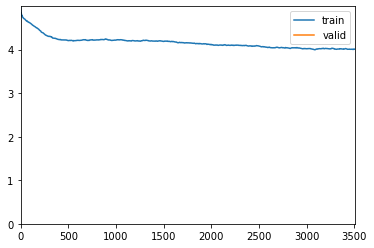

In [21]:
learn.fit_one_cycle(1, 2e-2)

### Saving and Loading Models
You can easily save the state of your model like so:

In [23]:
learn.save('IMDb_LM_1epoch_frozen')

In [15]:
learn.path

Path('../../Datasets/NLP/IMBd')

This will create a file in `learn.path/models/` named *IMDb_LM_1epoch_frozen.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [ ]:
learn = learn.load('IMDb_LM_1epoch_frozen')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [ ]:
learn.save_encoder('finetuned_IMDb_LM')

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation AFTER FINETUNNNG WITH IMDB (Just for fun :D)
Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [ ]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

In [13]:
TEXT        = "I liked this movie because"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

i liked this movie because of its similarity to the Emmy Award - winning film , The Godfather . The film 's two main characters , Elliot ( Dennis Medal ) and Benjamin ( George

i liked this movie because it was " a small , funny , open - air show , " and " like a movie that 's really funny " , Succinct noted : " To what 's going on , i needed a

i liked this movie because it was a " huge film " . Although he made a good deal of treehouse films , he did not like the idea that the movie was going to be a big success . In an interview

i liked this movie because of the " a [ sic ] well [ depicted ] story " . The film received positive reviews from critics , who praised the production of the film as well as the acting , though Brian

i liked this movie because it was a movie , and he took it on a " detailed " basis . He described the film as a " tremendous steel video " of a character he had " never seen before " .


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (*I* is just transformed to *i* because our rules require two characters or more to consider a word as capitalized, so it's normal to see it lowercased) and is using consistent tense. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

# <center> END
<center> We have fintuned the Language Model with the IMDb dataset.
<center> The next step is using that model to train a classifier.